In [1]:
import matplotlib.pyplot as plt
import open3d as o3d
import os
import sys
import h5py
from sklearn.decomposition import PCA 
import json
from sklearn.model_selection import train_test_split
import numpy as np
sys.path.append("../..")
sys.path.append("..")   
from data.utils import distinct_colors
from models.datasets import SorghumDatasetWithNormals, TreePartNetDataset, TreePartNetOriginalDataset, SorghumDatasetTPNFormat
from models.nn_models import *
from data.load_raw_data import load_real_ply_with_labels, load_pcd_plyfile_new_approach
from data.utils import distinct_colors
from train_and_inference.test import *
from models.utils import LeafMetrics

plt.style.use('seaborn')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def load_full_size_synthetic(ind, path, is_instance = False):
    file_names = os.listdir(path)

    _, test_names = train_test_split(
        file_names,
        test_size=0.2,
        random_state=42,
    )
    
    pcd = load_pcd_plyfile_new_approach(os.path.join(path,f"{test_names[ind]}"), is_instance)
    test_data = np.expand_dims(pcd['points_full'],0)
    test_labels = np.expand_dims(pcd['labels_full'],0)
    return test_data, test_labels

In [3]:
p_metric_calc = LeafMetrics("cpu")
c_metric_calc = ClusterBasedMetrics([0.25,0.5,0.75])

In [4]:
def draw_results(plt_points, plt_labels, plt_preds):
    fig = plt.figure(figsize=(10,10))
    
    all_labels = list(set(plt_labels))
    if len(all_labels) == 3:
        d_colors = [[0.5, 0.2, 0.1], [0, 0.7, 0], [0, 0, 0.7]]
    else:
        d_colors = distinct_colors(len(all_labels))

    gt_colors = np.zeros((plt_labels.shape[0],3))
    for i, l in enumerate(all_labels):
        gt_colors[plt_labels == l, :] = d_colors[i]

    all_labels = list(set(plt_preds))
    if len(all_labels) == 3:
        d_colors = [[0.5, 0.2, 0.1], [0, 0.7, 0], [0, 0, 0.7]]
    else:
        d_colors = distinct_colors(len(all_labels))
        
    pred_colors = np.zeros((plt_preds.shape[0],3))
    for i, l in enumerate(list(set(plt_preds))):
        pred_colors[plt_preds == l, :] = d_colors[i]

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.scatter(plt_points[:,0],plt_points[:,1],plt_points[:,2], s=5, c=gt_colors, alpha=1)
    ax1.grid(False)
    ax1.axis("off")
    ax1.set_facecolor("white")
    
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(plt_points[:,0],plt_points[:,1],plt_points[:,2], s=5, c=pred_colors, alpha=1)
    ax2.grid(False)
    ax2.axis("off")
    ax2.set_facecolor("white")

    plt.tight_layout()
    plt.show()

def draw_and_save_pcd_plot(plt_labels, pca_raw_preds, prefix):
    if pca_raw_preds is not None:
        plt.style.use('default')

        pca_2d = PCA(n_components = 2)
        pca_2d.fit(pca_raw_preds)
        data_pca_2d = pca_2d.transform(pca_raw_preds)
        
        d_colors = distinct_colors(len(list(set(plt_labels))))
        colors = np.zeros((plt_labels.shape[0],3))
        for i, l in enumerate(list(set(plt_labels))):
            colors[plt_labels == l, :3] = d_colors[i]
            
        fig = plt.figure(figsize=(10,10))
        ax1 = fig.add_subplot(1, 1, 1)
        ax1.scatter(data_pca_2d[:,0],data_pca_2d[:,1], s=5, c=colors*1.4)
        ax1.set_facecolor("white")
        ax1.spines['left'].set_color('black')
        ax1.spines['bottom'].set_color('black')
        fig.savefig(f"{prefix}_pca_plt.png")

        plt.style.use('seaborn')

def get_color_array(labels):
    all_labels = list(set(labels))
    if len(all_labels) == 3:
        d_colors = [[0.5, 0.2, 0.1], [0, 0.7, 0], [0, 0, 0.7]]
    else:
        d_colors = distinct_colors(len(all_labels))

    colors = np.zeros((labels.shape[0],3))
    for i, l in enumerate(all_labels):
        colors[labels == l, :] = d_colors[i]
    
    return colors

def draw_comparative_figures(plt_points, plt_labels, EXP1_plt_preds, EXP2_plt_preds, EXP1_pca_raw_preds, EXP2_pca_raw_preds, prefix):
    pca_2d = PCA(n_components = 2)
    pca_2d.fit(EXP1_pca_raw_preds)
    EXP1_data_pca_2d = pca_2d.transform(EXP1_pca_raw_preds)
    pca_2d.fit(EXP2_pca_raw_preds)
    EXP2_data_pca_2d = pca_2d.transform(EXP2_pca_raw_preds)

    gt_colors = get_color_array(plt_labels)
    EXP1_colors = get_color_array(EXP1_plt_preds)
    EXP2_colors = get_color_array(EXP2_plt_preds)
    
    fig = plt.figure(figsize=(10,10))
    
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax1.scatter(plt_points[:,0],plt_points[:,1],plt_points[:,2], s=5, c=gt_colors*1.4, alpha=1)
    ax1.grid(False)
    ax1.axis("off")
    ax1.set_facecolor("white")
    
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax2.scatter(plt_points[:,0],plt_points[:,1],plt_points[:,2], s=5, c=EXP1_colors, alpha=1)
    ax2.grid(False)
    ax2.axis("off")
    ax2.set_facecolor("white")

    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ax3.scatter(plt_points[:,0],plt_points[:,1],plt_points[:,2], s=5, c=EXP2_colors, alpha=1)
    ax3.grid(False)
    ax3.axis("off")
    ax3.set_facecolor("white")

    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(10,5))
    ax4 = fig.add_subplot(1, 2, 1)
    # ax4.set_facecolor("white")
    # ax4.spines['left'].set_color('black')
    # ax4.spines['bottom'].set_color('black')
    ax4.scatter(EXP1_data_pca_2d[:,0],EXP1_data_pca_2d[:,1], s=5, c=gt_colors*1.4)
    
    ax5 = fig.add_subplot(1, 2, 2)
    ax5.scatter(EXP2_data_pca_2d[:,0],EXP2_data_pca_2d[:,1], s=5, c=gt_colors*1.4)

    plt.tight_layout()
    plt.show()

In [5]:
# Find indices of real where AP and AR are higher for Exp 08 compared to Exp 04
base_path = "/speedy/ariyanzarei/sorghum_segmentation/results/inference_logs/SorghumPartNetInstance/SPNS/"
base_path_2 = "/speedy/ariyanzarei/sorghum_segmentation/results/inference_logs/TreePartNet/SPNS/"

exp_08_all_res = load_json(os.path.join(base_path,"EXP_08","test_set", "full_results.json"))
exp_04_all_res = load_json(os.path.join(base_path_2,"EXP_04","test_set", "full_results.json"))

all_indices = None
for key in ['clusterbased_average_precisions','clusterbased_average_recalls']:
    metric_08 = np.array(exp_08_all_res[key])
    metric_04 = np.array(exp_04_all_res[key])
    # indices = np.argpartition(metric_08 - metric_04, -2)[-2:]
    indices = np.where(metric_08>metric_04)[0]
    if all_indices is None:
        all_indices = indices
    else:
        all_indices = np.intersect1d(all_indices, indices)
    print(key, len(indices),"/", len(metric_08), indices)
print("All Metrics", len(all_indices),"/", len(metric_08), all_indices)
ap = np.array(exp_08_all_res['clusterbased_average_precisions'])[all_indices]-np.array(exp_04_all_res['clusterbased_average_precisions'])[all_indices]
sub_indices = np.argpartition(ap, -10)[-10:]
print(all_indices[sub_indices])
print(ap[sub_indices])

clusterbased_average_precisions 12539 / 12800 [    0     1     2 ... 12797 12798 12799]
clusterbased_average_recalls 12791 / 12800 [    0     1     2 ... 12797 12798 12799]
All Metrics 12536 / 12800 [    0     1     2 ... 12797 12798 12799]
[12181  2753  1216  6983  1632  7712  7486  7412  1202  9427]
[0.77124183 0.7724359  0.77380952 0.77492877 0.775      0.78571429
 0.77575758 0.7797619  0.78611111 0.77622378]


In [6]:
EXP1_model_name = "SorghumPartNetInstance"
EXP1_trained_dataset = "SPNS"
EXP1_exp_no = "08"
EXP1_experiment_param_path = f"/speedy/ariyanzarei/sorghum_segmentation/experiments/{EXP1_model_name}/{EXP1_trained_dataset}/EXP_{EXP1_exp_no}_{EXP1_model_name}_{EXP1_trained_dataset}.json"
EXP1_hyper_param_path = f"/speedy/ariyanzarei/sorghum_segmentation/results/hparam_tuning_logs/{EXP1_model_name}/{EXP1_trained_dataset}/EXP_{EXP1_exp_no}/DBSCAN_best_param.json"

EXP1_experiment_params = load_json(EXP1_experiment_param_path)

EXP1_dataset_name = EXP1_experiment_params["dataset"]
EXP1_dataset_path = EXP1_experiment_params["test_data"]
EXP1_model_name = EXP1_experiment_params["model_name"]
EXP1_experiment_id = EXP1_experiment_params["experiment_id"]
if EXP1_dataset_name == "SPNS":
    EXP1_point_key, EXP1_label_key = "points", "labels"
elif EXP1_dataset_name == "TPN":
    EXP1_point_key, EXP1_label_key = "points", "primitive_id"
EXP1_model_path = os.path.join(
        "/speedy/ariyanzarei/sorghum_segmentation/results",
        "training_logs",
        EXP1_model_name,
        EXP1_dataset_name,
        EXP1_experiment_id,
        "checkpoints",
    )
EXP1_model = load_model(EXP1_model_name, EXP1_model_path)
EXP1_hparams = load_json(EXP1_hyper_param_path)
print(f"EXP_{EXP1_exp_no} ==> ", EXP1_hparams)

EXP_08 ==>  {'eps': 2.008001479451607, 'minpoints': 19.0}


In [11]:
EXP2_model_name = "TreePartNet"
EXP2_trained_dataset = "SPNS"
EXP2_exp_no = "04"
EXP2_experiment_param_path = f"/speedy/ariyanzarei/sorghum_segmentation/experiments/{EXP2_model_name}/{EXP2_trained_dataset}/EXP_{EXP2_exp_no}_{EXP2_model_name}_{EXP2_trained_dataset}.json"
# EXP2_hyper_param_path = f"/speedy/ariyanzarei/sorghum_segmentation/results/hparam_tuning_logs/{EXP2_model_name}/{EXP2_trained_dataset}/EXP_{EXP2_exp_no}/DBSCAN_best_param.json"

EXP2_experiment_params = load_json(EXP2_experiment_param_path)

EXP2_dataset_name = EXP2_experiment_params["dataset"]
EXP2_dataset_path = EXP2_experiment_params["test_data"]
EXP2_model_name = EXP2_experiment_params["model_name"]
EXP2_experiment_id = EXP2_experiment_params["experiment_id"]
if EXP2_dataset_name == "SPNS":
    EXP2_point_key, EXP2_label_key = "points", "labels"
elif EXP2_dataset_name == "TPN":
    EXP2_point_key, EXP2_label_key = "points", "primitive_id"
EXP2_model_path = os.path.join(
        "/speedy/ariyanzarei/sorghum_segmentation/results",
        "training_logs",
        EXP2_model_name,
        EXP2_dataset_name,
        EXP2_experiment_id,
        "checkpoints",
    )
EXP2_model = load_model(EXP2_model_name, EXP2_model_path)
EXP2_hparams = None
# EXP2_hparams = load_json(EXP2_hyper_param_path)
# print(f"EXP_{EXP2_exp_no} ==> ", EXP2_hparams)

In [8]:
def run_inference_and_compare_synthetic(orig_ind):
    test_data, test_labels = load_full_size_synthetic(
        orig_ind,
        "/space/ariyanzarei/sorghum_segmentation/dataset/archive/synthetic/2022-12-26/PointCloud/",
        True,
    )
    ind = 0

    t_points = torch.from_numpy(test_data[ind]).type(torch.DoubleTensor)

    EXP1_raw_preds = EXP1_model(t_points.unsqueeze(0))
    EXP2_raw_preds = EXP2_model(t_points.unsqueeze(0))

    if EXP1_model_name == "SorghumPartNetInstance":
        EXP1_preds = get_final_clusters_SPN(
            EXP1_raw_preds, EXP1_hparams["eps"], EXP1_hparams["minpoints"]
        )
    elif EXP1_model_name == "TreePartNet":
        EXP1_preds = get_final_clusters_TPN(EXP1_raw_preds)

    if EXP2_model_name == "SorghumPartNetInstance":
        EXP2_preds = get_final_clusters_SPN(
                EXP2_raw_preds, EXP2_hparams["eps"], EXP2_hparams["minpoints"]
            )
    elif EXP2_model_name == "TreePartNet":
        EXP2_preds = get_final_clusters_TPN(EXP2_raw_preds)

    
    print(
        f"EXP_{EXP1_exp_no}",
        p_metric_calc(
            torch.from_numpy(EXP1_preds).view(1, -1, 1),
            torch.from_numpy(test_labels[ind]).view(1, -1, 1),
        ),
    )
    print(
        f"EXP_{EXP2_exp_no}",
        p_metric_calc(
            torch.from_numpy(EXP2_preds).view(1, -1, 1),
            torch.from_numpy(test_labels[ind]).view(1, -1, 1),
        ),
    )

    print(
        f"EXP_{EXP1_exp_no}",
        c_metric_calc(
            torch.from_numpy(EXP1_preds), torch.from_numpy(test_labels[ind].squeeze())
        ),
    )
    print(
        f"EXP_{EXP2_exp_no}",
        c_metric_calc(
            torch.from_numpy(EXP2_preds), torch.from_numpy(test_labels[ind].squeeze())
        ),
    )

    draw_comparative_figures(
        test_data[ind],
        test_labels[ind].squeeze(),
        EXP1_preds,
        EXP2_preds,
        EXP1_raw_preds.squeeze().detach().numpy(),
        EXP2_raw_preds.squeeze().detach().numpy(),
        "",
    )

In [9]:
# [ 1006 10482  4493  8385  3974  7971  6870  7105  1782  4634]
# [12188 10139 10319  5068  7786  7926  2577  8318  6414  7712]
# [ 5044  8594 12027 11383  4841  2959   459  6852  5312  1538]
# [ 7971  8283 12164  6870  1782    699 4634  9123  7105  8122]

run_inference_and_compare_synthetic(0)

RuntimeError: points.scalar_type() == at::ScalarType::FloatINTERNAL ASSERT FAILED at "/net/i01/work/ariyanzarei/SorghumSegmentation/SorghumPartNet/models/_ext-src/src/sampling.cpp":68, please report a bug to PyTorch. points must be a float tensor

(0.6967768669128418, 0.3036435842514038, 0.5131489634513855, 0.38152745366096497)
{'mean_coverage': 0.2373664083385844, 'average_precision': 0.23809523809523805, 'average_recall': 0.20833333333333334}


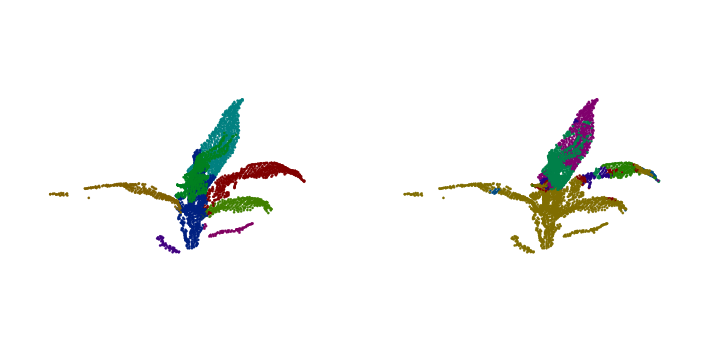

AttributeError: 'tuple' object has no attribute 'squeeze'

In [30]:
ind = 0
exp = "09"

model = EXP1_model if exp == "08" else EXP2_model
model_name = EXP1_model_name if exp == "08" else EXP2_model_name
hparams = EXP1_hparams if exp == "08" else EXP2_hparams
experiment_id = EXP1_experiment_id if exp == "08" else EXP2_experiment_id

points, label = load_data_directory("/space/ariyanzarei/sorghum_segmentation/dataset/SPNR", model_name)

if model_name == "TreePartNet":
    t_points = torch.from_numpy(points[ind]).type(torch.FloatTensor).to(torch.device("cuda"))
    model = model.to(torch.device("cuda"))
else:
    t_points = torch.from_numpy(points[ind]).type(torch.DoubleTensor)

raw_preds = model(t_points.unsqueeze(0))

if model_name == "SorghumPartNetSemantic":
    preds = F.softmax(raw_preds, dim=1)
    preds = preds.squeeze().cpu().detach().numpy().T
    preds = np.argmax(preds, 1)
    raw_preds = None
elif model_name == "SorghumPartNetInstance":
    preds = get_final_clusters_SPN(raw_preds, hparams['eps'], hparams['minpoints'])
elif model_name == "TreePartNet":
    preds = get_final_clusters_TPN(raw_preds, False, 0)
    preds = preds.numpy()

print(p_metric_calc(torch.from_numpy(preds).view(1,-1,1), torch.from_numpy(label[ind]).view(1,-1,1)))
print(c_metric_calc(torch.from_numpy(preds), torch.from_numpy(label[ind])))

draw_results(points[ind], label[ind], preds)
draw_and_save_pcd_plot(label[ind].squeeze(),raw_preds.squeeze().detach().numpy(),f"{experiment_id}_real_{ind}")

gt_ply = create_ply_pcd_from_points_with_labels(points[ind],label[ind])
pred_ply = create_ply_pcd_from_points_with_labels(points[ind],preds)

R = o3d.geometry.get_rotation_matrix_from_xyz((-np.pi/2, 0, 0))
gt_ply.rotate(R, center=(0, 0, 0))
pred_ply.rotate(R, center=(0, 0, 0))

o3d.io.write_point_cloud(f"{experiment_id}_real_{ind}_gt.ply", gt_ply)
o3d.io.write_point_cloud(f"{experiment_id}_real_{ind}_pred.ply", pred_ply)

(0.9500261545181274, 0.6875472664833069, 0.7734933495521545, 0.7279924154281616)
{'mean_coverage': 0.7288114833373232, 'average_precision': 0.7142857142857143, 'average_recall': 0.7692307692307692}


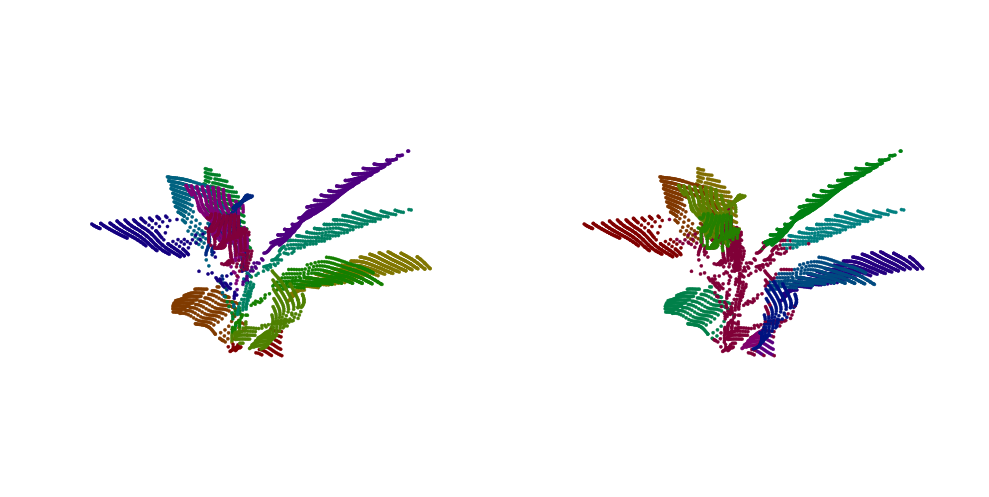

True

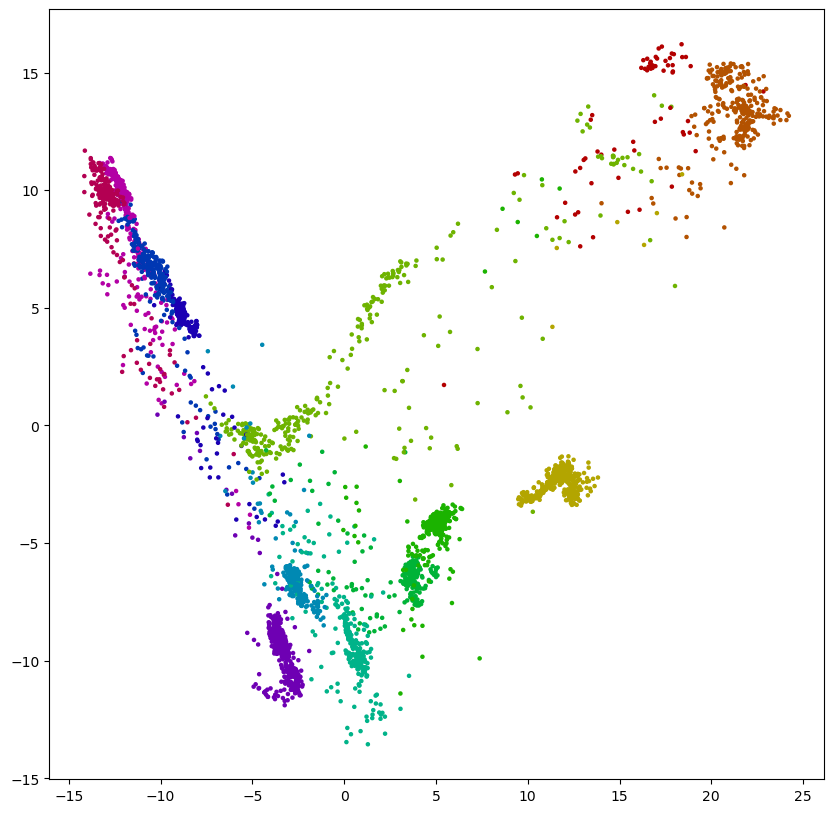

In [142]:
# hparams = {"eps": 1, "minpoints": 15}

orig_ind = 9123
exp = "09"

model = EXP1_model if exp == "08" else EXP2_model
model_name = EXP1_model_name if exp == "08" else EXP2_model_name
hparams = EXP1_hparams if exp == "08" else EXP2_hparams
experiment_id = EXP1_experiment_id if exp == "08" else EXP2_experiment_id

test_data, test_labels = load_full_size_synthetic(orig_ind,"/space/ariyanzarei/sorghum_segmentation/dataset/archive/synthetic/2022-12-26/PointCloud/", True)
ind = 0

t_points = torch.from_numpy(test_data[ind]).type(torch.DoubleTensor)

raw_preds = model(t_points.unsqueeze(0))

if model_name == "SorghumPartNetInstance":
    preds = get_final_clusters_SPN(raw_preds, hparams['eps'], hparams['minpoints'])
elif model_name == "TreePartNet":
    preds = get_final_clusters_TPN(raw_preds)

print(p_metric_calc(torch.from_numpy(preds).view(1,-1,1), torch.from_numpy(test_labels[ind]).view(1,-1,1)))
print(c_metric_calc(torch.from_numpy(preds), torch.from_numpy(test_labels[ind].squeeze())))

draw_results(test_data[ind], test_labels[ind].squeeze(), preds)
draw_and_save_pcd_plot(test_labels[ind].squeeze(),raw_preds.squeeze().detach().numpy(),f"{experiment_id}_syn_{orig_ind}")

save_points = (test_data[ind] - np.min(test_data[ind], 0))
gt_ply = create_ply_pcd_from_points_with_labels(save_points,test_labels[ind].squeeze())
pred_ply = create_ply_pcd_from_points_with_labels(save_points,preds)

R = o3d.geometry.get_rotation_matrix_from_xyz((-np.pi/2, 0, 0))
gt_ply.rotate(R, center=(0, 0, 0))
pred_ply.rotate(R, center=(0, 0, 0))

o3d.io.write_point_cloud(f"{experiment_id}_syn_{orig_ind}_gt.ply", gt_ply)
o3d.io.write_point_cloud(f"{experiment_id}_syn_{orig_ind}_pred.ply", pred_ply)